### Install dependencies

In [2]:
!pip install pythonperlin

  Preparing metadata (setup.py) ... done
  Created wheel for pythonperlin: filename=pythonperlin-0.0.8-py3-none-any.whl size=6388 sha256=740d7b7d2e966eeefedd402925eba31c31fe3798a767cd0626ec22b08e20afcc
  Stored in directory: /root/.cache/pip/wheels/a9/93/ed/2c595c1a84aaf65ef6640cbf71533d1c7c74e29dc058b98c9e
Successfully built pythonperlin


In [3]:
import time

import numpy as np
import matplotlib.pyplot as plt
from pythonperlin import perlin
import random

In [4]:
t = np.linspace(0, 500, 1000)       # time
R = 100  # Total finite resources
N = 5   # Number of civilizations
initial_resources = R / N  # Initial resources for each civilization
P_i = 0.1  # Probability of being detected if communicating
D_i = 0.9  # Probability of destruction if detected
tau = 50   # Threat threshold
alpha = 0.01  # Decay rate for survival probability
C_i = 0.5  # Collaboration coefficient
R_i = 0.3  # Risk coefficient

In [5]:
def perlin_function(t, dens=100):
    n = len(t)
    shape = (1,int(n/dens))

    # Generate noise
    x = perlin(shape, dens=dens, seed=random.randint(0,99999))
    # get the first channel
    x = x[0]
    return x


### Expansion function
E_i(t) over time for a civilization
Assume:
- every civilisation would require a certain amount of resources to expand
- it is easier to expand at the beginning as it requires less resources then expand after a long time (it would require more resources)
- expansion by itself increasing over the time

In [6]:
# Expansion function E_i(t) over time for a civilization
def expansion_function(t):
    return 1 - np.exp(-t/100)

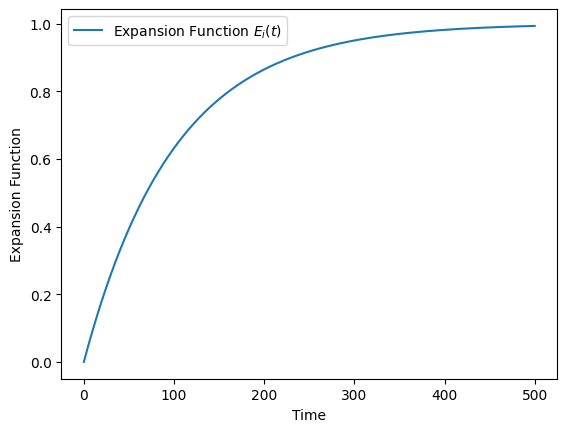

In [7]:
plt.plot(t, expansion_function(t), label='Expansion Function $E_i(t)$')
plt.xlabel('Time')
plt.ylabel('Expansion Function')
plt.legend()

### Resources function
Resources function R(t) over time for a civilization
Assume:
 Total finite resources

In [8]:
# Resources function R(t) over time for a civilization
def resources_function(t):
    return np.ones_like(t) * R

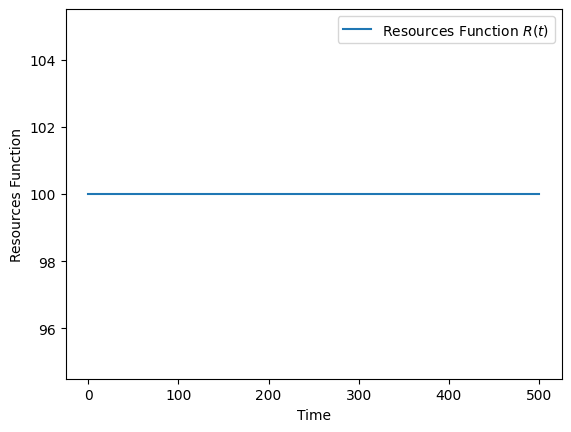

In [9]:
plt.plot(t, resources_function(t), label='Resources Function $R(t)$')
plt.xlabel('Time')
plt.ylabel('Resources Function')
plt.legend()


### Resources scarcity function
Resources scarcity function S(t) over time
- resources scarcity function S(t) is a function of time for N civilizations
- 0 to 1, where 0 means no scarcity and 1 means all resources are used up

In [10]:
# Resources scarcity function S(t) over time
def resources_scarcity_function(t):
    return 1 - (R - N * initial_resources * expansion_function(t)) / R


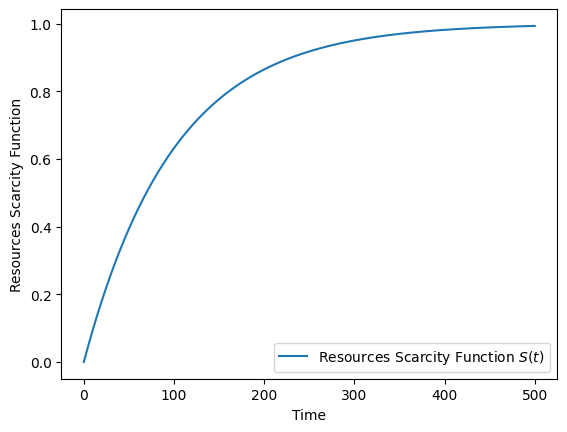

In [11]:
plt.plot(t, resources_scarcity_function(t), label='Resources Scarcity Function $S(t)$')
plt.xlabel('Time')
plt.ylabel('Resources Scarcity Function')
plt.legend()

### Risk coefficient and black swans
- risk coefficient consiost from original risks base, black swans (random rare big events), small correlations over time (noise)

In [12]:
def risk_coefficient(t, coef=0.01, R_i=0.3, black_swans=0.01):
    #  base risk level higher at the beginning and reduces over a time with coefficient
    risk = R_i * np.exp(-t * coef)
    # Black swans
    black_swans = np.random.rand(*t.shape) < black_swans
    risk += R_i * black_swans * np.random.rand(*t.shape) * 4
    # Small correlations over time (perlin noise)
    # generate noise
    prl = perlin_function(t) * .3
    prl += perlin_function(t, 10) * .05
    prl += perlin_function(t, 2) * .02
    risk += R_i * prl
    # risk should be between 0 and 1
    risk = np.clip(risk, 0, 1)

    return risk

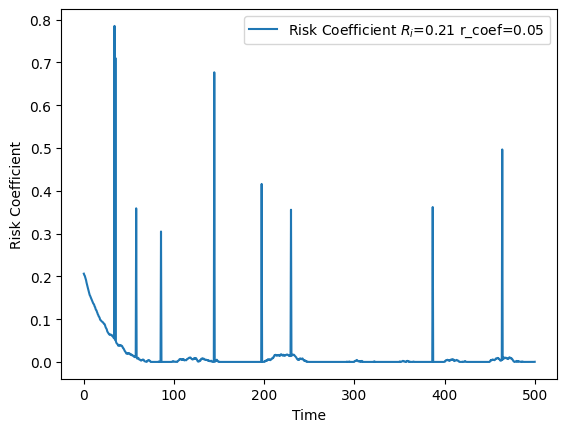

In [13]:
r_coef = random.random() * .05
R_i = random.random() * .3
black_swans = .01
risk = risk_coefficient(t, coef=r_coef, R_i=R_i, black_swans=black_swans)

plt.plot(t, risk, label='Risk Coefficient $R_i$={:.2f} r_coef={:.2f}'.format(R_i, r_coef))
plt.xlabel('Time')
plt.ylabel('Risk Coefficient')
plt.legend()

### Black swans for the advanced technology or knowledge

In [14]:
def black_swans(t, bs_prob=0.01):
    # seed
    np.random.seed(random.randint(0,99999))
    black_swans = np.random.rand(*t.shape) < bs_prob
    black_swans = black_swans * np.random.rand(*t.shape) * 0.1
    # sum up black swans
    bs_sum = []
    for i in range(len(t)):
        bs_sum.append(np.sum(black_swans[0:i]))

    return (bs_sum, black_swans)

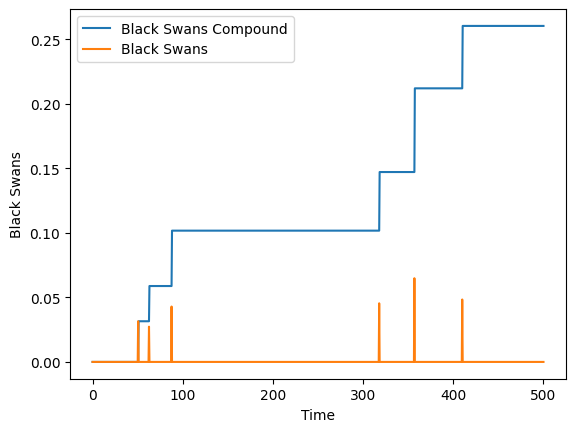

In [15]:
bs_prob = 0.01
bs_sum, bl_sw = black_swans(t, bs_prob=bs_prob)

plt.plot(t, bs_sum, label='Black Swans Compound')
plt.plot(t, bl_sw, label='Black Swans')
plt.xlabel('Time')
plt.ylabel('Black Swans')
plt.legend()

### Collaboration function
- low at the beginning, increase over time as they adapt to each other and became more depend on each other, longer period of collaboration 0- more trust also
- over time coefficient of trust grow and in case of black swan events it would improve collaboaration and increase survival
- collaboration increasing survival as if one civilization makes some progress they share knowledge
- collaboration leads to increasing diversification, which reduce the risks of extinction
- collaboration have some tax for preserving less adapted species
- collaboration have a risk coefficient, that higher at the begining when they not know each other, so, it should be more caucious
- gradual growth and competition, here is no strategic advantage over competing species
- evolution very slow, time to adapt to changes

In [16]:
def remap(x, x_min, x_max, y_min, y_max):
    return (x - x_min) / (x_max - x_min) * (y_max - y_min) + y_min

In [17]:
def collaboration_function(t, risk, bs_sum, r_aver=20, adapt=30, R_i=0.3):
    # Collaboration coefficient C_i low at the beginning and increase over time with coefficient pow as the relationships became more tight and they both depend from each other
    # at the beginning collaboration can be negative as it take time (adapt coefficient) to adapt to each other ln(t)
    # if trust negative the risk should be higher, higher trust - lower risk
    col_f = -R_i + np.log(t + 1) / np.log(adapt)
    # map it 0 to .5 range, not clip
    col_f = remap(col_f, 0, max(col_f), 0, 0.8)
    # add risk coefficient
    # risk is average for the last r_aver period
    r_averg = []
    for i in range(len(t)):
        r_averg.append(np.mean(risk[max(0, i - r_aver):i]))
    col_f -= r_averg * remap(col_f, -R_i, 1, 3, 2)

    # add black swans (positive, they can represent some advanced technology or knowledge)

    col_f += bs_sum

    return col_f

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


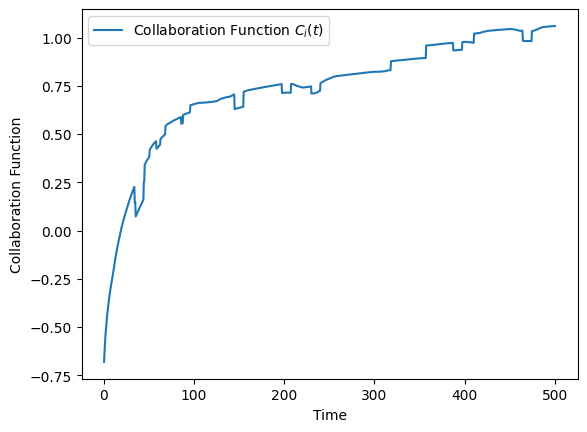

In [18]:
col_f = collaboration_function(t, risk, bs_sum, 20)

plt.plot(t, col_f, label='Collaboration Function $C_i(t)$')
plt.xlabel('Time')
plt.ylabel('Collaboration Function')
plt.legend()

### Survival probability function with collaboration
take the general survival that over time reduces as there more chances to die or destroy itself, take into account the risks that reducing survival, and collaboration that increasing survival

In [19]:
def survival_probability_function(t, risk, col_f, alpha=0.01, risk_coef=0.1):
    # Survival probability function S_i(t) over time for a civilization
    # survival probability is 1 at the beginning and reduces over time with decay rate alpha
    # if risk is high survival probability is lower
    # if collaboration is high survival probability is higher
    # compound risks (all previous risks are summed up)
    # base survival probability
    survival = np.exp(-alpha * t)
    # risks
    risks = []
    for i in range(len(t)):
        risks.append(np.sum(risk[0:i]) * risk_coef)
    survival -= risks
    # collaboration
    survival += col_f

    return survival

In [20]:
alpha = 0.01
risk_coef = random.random() * .2
survival = survival_probability_function(t, risk, col_f, alpha, risk_coef)
exp_survival = expansion_function(t) * survival

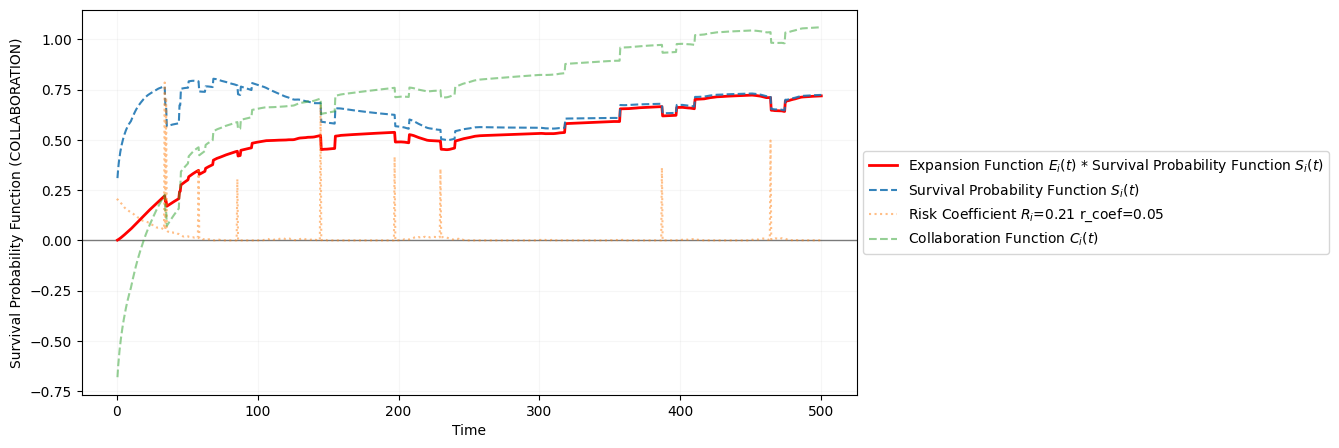

In [21]:
plt.xlabel('Time')
plt.ylabel('Survival Probability Function (COLLABORATION)')
plt.grid(alpha=0.1)
plt.axhline(0, color='black', lw=1, alpha=0.5)
plt.plot(t, exp_survival, label='Expansion Function $E_i(t)$ * Survival Probability Function $S_i(t)$', color='red', lw=2)
plt.plot(t, survival, label='Survival Probability Function $S_i(t)$', alpha=0.9, linestyle='dashed')
plt.plot(t, risk, label='Risk Coefficient $R_i$={:.2f} r_coef={:.2f}'.format(R_i, r_coef), alpha=0.5, linestyle='dotted')
plt.plot(t, col_f, label='Collaboration Function $C_i(t)$', alpha=0.5, linestyle='dashed')
# legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.gcf().set_size_inches(10, 5)

### Competition function
- competition lead to wars
- competition  blocking the technology, that reducing survival too (patents and secres, technology wars and spying)
- reducing trust
- monopolisation when it capture the power
- multipolar trup lead to take more risks as there the cost for any time spent as another civilisation can take advantage of a new technology
- over time risks increasing as there less trust and more initiative to play dirty or rush to the end to win the race
- at the begining it can increase survival because of optimization, but at the end optimisation reduce the effort, but increasing the risks
- technology and arm race that requires more and more resources over time
- the cost of hiding (bigger the civilisation - higher the cost to hide), at the end it putting cap on the development

In [22]:
def competition_function(t, risk, col_f, bs_sum, alpha, adapt=30, R_i=0.3, r_aver=20):
    # Competition coefficient C_i low at the beginning and increase over time as  over time competition require more and more resources
    # t - time
    # risk - risks
    # bs_sum -  black swans events
    # adapt - time for adaptation
    # alpha - coefficient for increasing of cost over time
    cost = alpha * np.log(t + 1) / np.log(adapt)
    # cost = remap(cost, 0, 1, 0, 0.5)

    # cost = remap(np.log(t + 1) / np.log(adapt), 0, 1, 0, 0.5)
    #add risks, over time risks would increase

    r_averg = []
    for i in range(len(t)):
        r_averg.append(np.mean(risk[max(0, i - r_aver):i]))
    cost += r_averg * remap(cost, -R_i, 1, 3, 2)
    cost += bs_sum

    # add cost of hiding (over time the cost would grow)

    # invert it as cost reduces survival
    return 1 - cost
    return cost

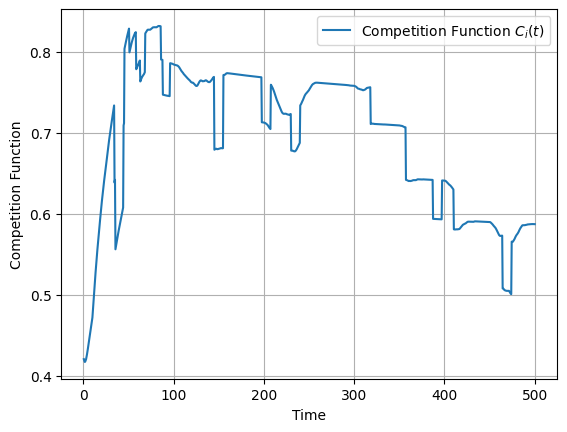

In [23]:
alpha = random.random() * .3
comp_f = competition_function(t, risk, col_f, bs_sum, alpha)

plt.plot(t, comp_f, label='Competition Function $C_i(t)$')
plt.xlabel('Time')
plt.ylabel('Competition Function')
plt.legend()
plt.grid()


### Survival probability function with competition

In [24]:
def survival_probability_function_comp(t, risk, comp, alpha=0.01, risk_coef=0.1):
    # Survival probability function S_i(t) over time for a civilization
    # survival probability is 1 at the beginning and reduces over time with decay rate alpha
    # if risk is high survival probability is lower
    # if collaboration is high survival probability is higher
    # compound risks (all previous risks are summed up)
    # base survival probability
    survival = np.exp(-alpha * t)
    # risks
    risks = []
    for i in range(len(t)):
        risks.append(np.sum(risk[0:i]) * risk_coef)
    survival -= risks
    # # collaboration
    survival += comp

    return survival

In [25]:
alpha = 0.01
risk_coef = random.random() * .2
survival_comp = survival_probability_function_comp(t, risk, comp_f, alpha, risk_coef)
exp_survival_comp = expansion_function(t) * survival_comp

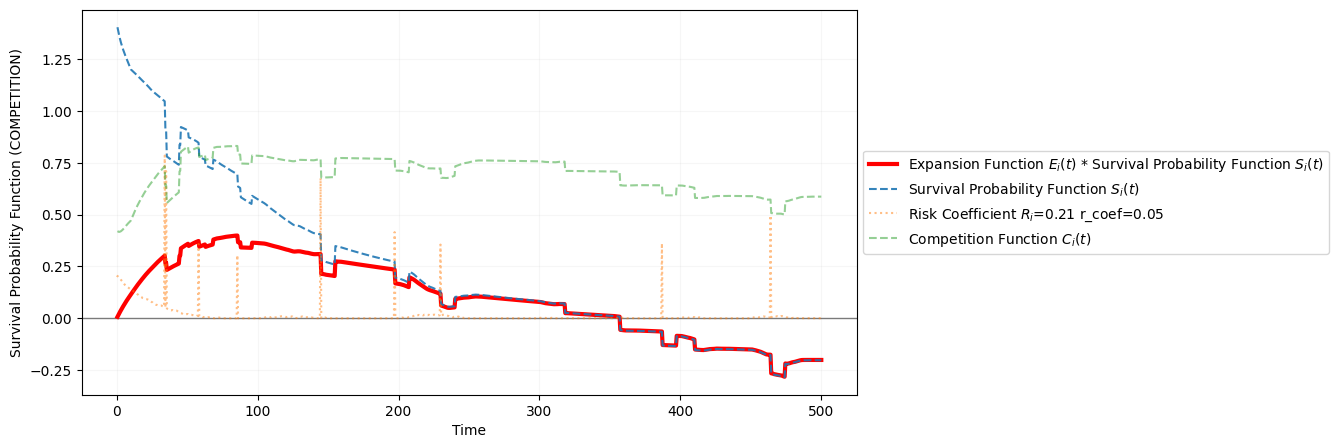

In [26]:
plt.xlabel('Time')
plt.ylabel('Survival Probability Function (COMPETITION)')
plt.grid(alpha=0.1)
plt.axhline(0, color='black', lw=1, alpha=0.5)
plt.plot(t, exp_survival_comp, label='Expansion Function $E_i(t)$ * Survival Probability Function $S_i(t)$', color='red', lw=3)
plt.plot(t, survival_comp, label='Survival Probability Function $S_i(t)$', alpha=0.9, linestyle='dashed')
plt.plot(t, risk, label='Risk Coefficient $R_i$={:.2f} r_coef={:.2f}'.format(R_i, r_coef), alpha=0.5, linestyle='dotted')
plt.plot(t, comp_f, label='Competition Function $C_i(t)$', alpha=0.5, linestyle='dashed')
# legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.gcf().set_size_inches(10, 5)

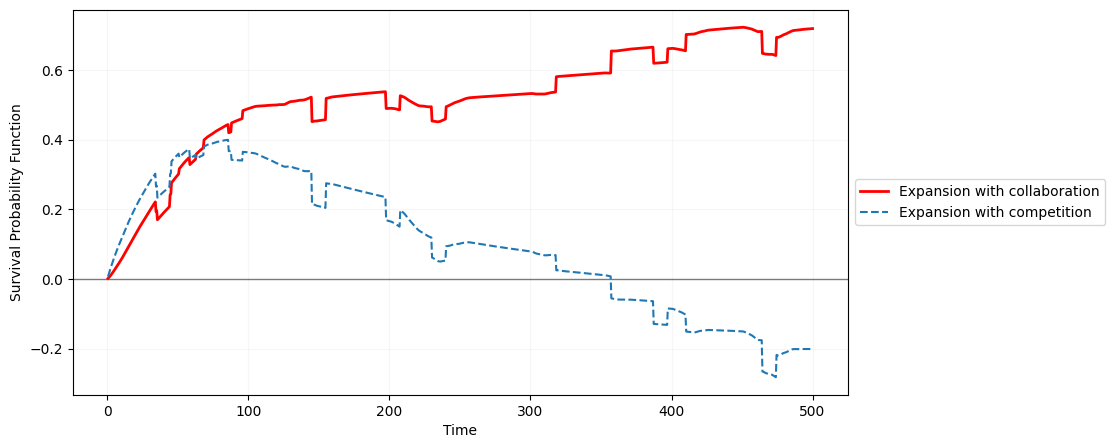

In [27]:
plt.xlabel('Time')
plt.ylabel('Survival Probability Function')
plt.grid(alpha=0.1)
plt.axhline(0, color='black', lw=1, alpha=0.5)
plt.plot(t, exp_survival, label='Expansion with collaboration', color='red', lw=2)
plt.plot(t, exp_survival_comp, label='Expansion with competition', linestyle='dashed')

# legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.gcf().set_size_inches(10, 5)

## Run multiple

In [28]:
import time

def run_sim():
    random.seed(time.time())

    t = np.linspace(0, 500, 1000)

    r_coef = random.random() * .05
    R_i = random.random() * .3
    black_swans_chance = .01
    risk = risk_coefficient(t, coef=r_coef, R_i=R_i, black_swans=black_swans_chance)

    bs_prob = 0.01
    bs_sum, bl_sw = black_swans(t, bs_prob=bs_prob)

    # collaboration
    col_f = collaboration_function(t, risk, bs_sum, 20)
    alpha = 0.01
    risk_coef = random.random() * .2
    survival_col = survival_probability_function(t, risk, col_f, alpha, risk_coef)
    exp_survival_col = expansion_function(t) * survival_col

    # competition
    alpha = random.random() * .3
    comp_f = competition_function(t, risk, col_f, bs_sum, alpha)
    alpha = 0.01
    risk_coef = random.random() * .2
    survival_comp = survival_probability_function_comp(t, risk, comp_f, alpha, risk_coef)
    exp_survival_comp = expansion_function(t) * survival_comp

    return exp_survival_col, survival_col, exp_survival_comp, survival_comp, bl_sw, risk

In [29]:
R_N = 5

exp_survival_col_av = np.zeros_like(t)
survival_col_av = np.zeros_like(t)
exp_survival_comp_av = np.zeros_like(t)
survival_comp_av = np.zeros_like(t)
bl_sw_av = np.zeros_like(t)
risk_v = np.zeros_like(t)

for i in range(R_N):
    exp_survival_col, survival_col, exp_survival_comp, survival_comp, bl_sw, risk = run_sim()
    exp_survival_col_av += exp_survival_col / R_N
    survival_col_av += survival_col / R_N
    exp_survival_comp_av += exp_survival_comp / R_N
    survival_comp_av += survival_comp / R_N
    bl_sw_av += bl_sw / R_N
    risk_v += risk / R_N

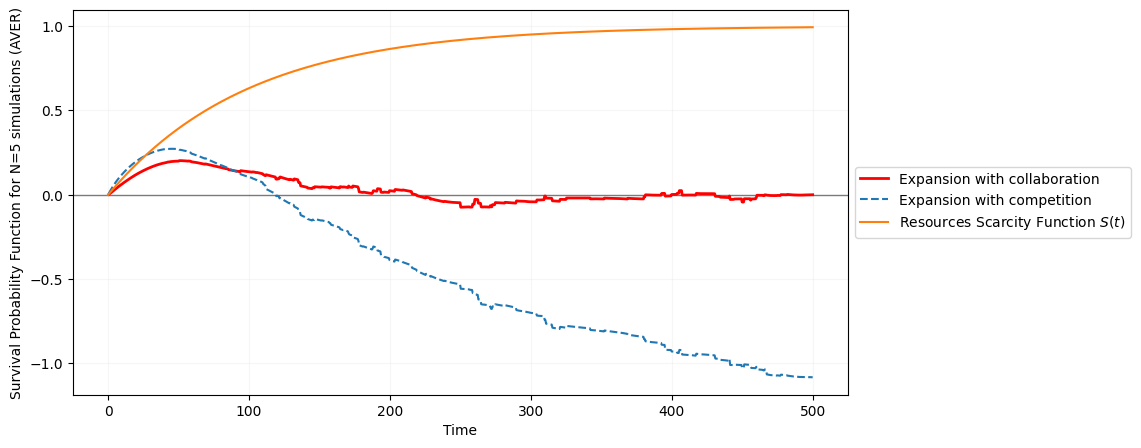

In [30]:
plt.xlabel('Time')
plt.ylabel('Survival Probability Function for N=' + str(R_N) + ' simulations (AVER)')
plt.grid(alpha=0.1)
plt.axhline(0, color='black', lw=1, alpha=0.5)
plt.plot(t, exp_survival_col_av, label='Expansion with collaboration', color='red', lw=2)
plt.plot(t, exp_survival_comp_av, label='Expansion with competition', linestyle='dashed')
plt.plot(t, resources_scarcity_function(t), label='Resources Scarcity Function $S(t)$')


# legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.gcf().set_size_inches(10, 5)

In [31]:
R_N = 20

exp_survival_col_av = np.zeros_like(t)
survival_col_av = np.zeros_like(t)
exp_survival_comp_av = np.zeros_like(t)
survival_comp_av = np.zeros_like(t)
bl_sw_av = np.zeros_like(t)
risk_v = np.zeros_like(t)

for i in range(R_N):
    exp_survival_col, survival_col, exp_survival_comp, survival_comp, bl_sw, risk = run_sim()
    exp_survival_col_av += exp_survival_col / R_N
    survival_col_av += survival_col / R_N
    exp_survival_comp_av += exp_survival_comp / R_N
    survival_comp_av += survival_comp / R_N
    bl_sw_av += bl_sw / R_N
    risk_v += risk / R_N

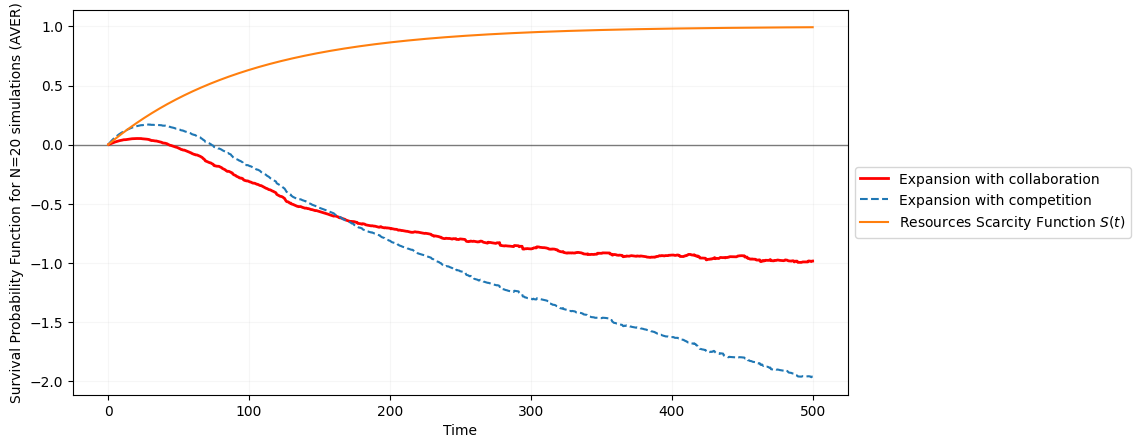

In [32]:
plt.xlabel('Time')
plt.ylabel('Survival Probability Function for N=' + str(R_N) + ' simulations (AVER)')
plt.grid(alpha=0.1)
plt.axhline(0, color='black', lw=1, alpha=0.5)
plt.plot(t, exp_survival_col_av, label='Expansion with collaboration', color='red', lw=2)
plt.plot(t, exp_survival_comp_av, label='Expansion with competition', linestyle='dashed')
plt.plot(t, resources_scarcity_function(t), label='Resources Scarcity Function $S(t)$')


# legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.gcf().set_size_inches(10, 5)

In [33]:
R_N = 500

exp_survival_col_av = np.zeros_like(t)
survival_col_av = np.zeros_like(t)
exp_survival_comp_av = np.zeros_like(t)
survival_comp_av = np.zeros_like(t)
bl_sw_av = np.zeros_like(t)
risk_v = np.zeros_like(t)

for i in range(R_N):
    exp_survival_col, survival_col, exp_survival_comp, survival_comp, bl_sw, risk = run_sim()
    exp_survival_col_av += exp_survival_col / R_N
    survival_col_av += survival_col / R_N
    exp_survival_comp_av += exp_survival_comp / R_N
    survival_comp_av += survival_comp / R_N
    bl_sw_av += bl_sw / R_N
    risk_v += risk / R_N

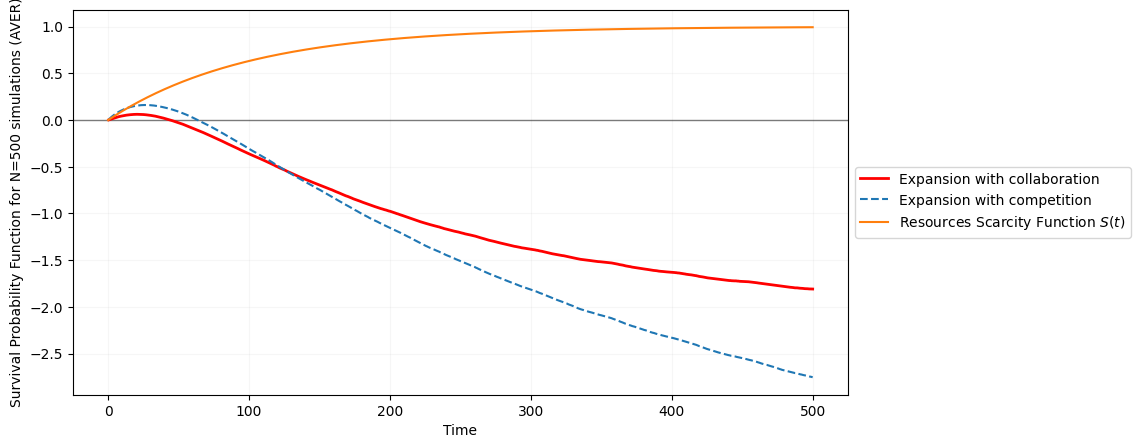

In [34]:
plt.xlabel('Time')
plt.ylabel('Survival Probability Function for N=' + str(R_N) + ' simulations (AVER)')
plt.grid(alpha=0.1)
plt.axhline(0, color='black', lw=1, alpha=0.5)
plt.plot(t, exp_survival_col_av, label='Expansion with collaboration', color='red', lw=2)
plt.plot(t, exp_survival_comp_av, label='Expansion with competition', linestyle='dashed')
plt.plot(t, resources_scarcity_function(t), label='Resources Scarcity Function $S(t)$')


# legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.gcf().set_size_inches(10, 5)

In the end, this is total speculation, just trying to be logical enough. I was thinking that maybe collaboration would let us get to the resource scarcity point, but over more and more simulations I see there is almost no chance for any civilization to reach the scarcity point, when the 'limited resources' axiom for the Dark Forest hypotheses start to work, so, I suppose this axiom are irrelevant.is